# Cálculo del quemado de un EE.CC. a partir de las cuentas neutrónicas del SICOM-NG-FA y otras variables de interés.

In [1]:
import pandas as pd

df = pd.read_csv("DataSet.csv", sep=';', index_col="ind")
print(df)

     EECC TipoEC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  \
ind                                                                          
1    BL09   MAEF        1  32458  146916  220.94       3       127   4.697   
2    BL09   MAEF        2  39967  150917  264.84       3       127   4.697   
3    BL09   MAEF        3  39438  145916  270.29       3       127   4.697   
4    BL09   MAEF        4  30342  145930  207.93       3       127   4.697   
5    BL09   MAEF        5  30361  140921  215.46       3       127   4.697   
..    ...    ...      ...    ...     ...     ...     ...       ...     ...   
142  BL15   MAEF        4  37083  140926  263.14       3       127   4.700   
143  BL21   MAEF        1  39939  142930  279.44       2       146   4.665   
144  BL21   MAEF        2  45292  143926  314.70       2       146   4.665   
145  BL21   MAEF        3  47127  144925  325.20       2       146   4.665   
146  BL21   MAEF        4  39936  142928  279.41       2       1

### Codificación de la categoría TipoEC

In [2]:
# df.TipoEC.value_counts()

In [3]:
dummies = pd.get_dummies(df['TipoEC'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop(columns=['TipoEC'])
print (df)

     EECC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU  \
ind                                                                            
1    BL09        1  32458  146916  220.94       3       127   4.697    44082   
2    BL09        2  39967  150917  264.84       3       127   4.697    46265   
3    BL09        3  39438  145916  270.29       3       127   4.697    46517   
4    BL09        4  30342  145930  207.93       3       127   4.697    43374   
5    BL09        5  30361  140921  215.46       3       127   4.697    43788   
..    ...      ...    ...     ...     ...     ...       ...     ...      ...   
142  BL15        4  37083  140926  263.14       3       127   4.700    46187   
143  BL21        1  39939  142930  279.44       2       146   4.665    47227   
144  BL21        2  45292  143926  314.70       2       146   4.665    48747   
145  BL21        3  47127  144925  325.20       2       146   4.665    49176   
146  BL21        4  39936  142928  279.4

### Reordeno los datos y elimino varias columnas [Cnn y T(ms), porque son combinación lineal de Cnn/s; AEF, porque es la ausencia de MAEF, OFA y STD simultáneamente]

In [4]:
df = df [['EECC', 'Muestra', 'MAEF', 'OFA', 'STD', 'Cnn/s', 'Ciclos', 'Enf(mes)', 'Enr(%)', 'Mwd/TnU']]
print(df)

     EECC  Muestra  MAEF  OFA  STD   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU
ind                                                                          
1    BL09        1     1    0    0  220.94       3       127   4.697    44082
2    BL09        2     1    0    0  264.84       3       127   4.697    46265
3    BL09        3     1    0    0  270.29       3       127   4.697    46517
4    BL09        4     1    0    0  207.93       3       127   4.697    43374
5    BL09        5     1    0    0  215.46       3       127   4.697    43788
..    ...      ...   ...  ...  ...     ...     ...       ...     ...      ...
142  BL15        4     1    0    0  263.14       3       127   4.700    46187
143  BL21        1     1    0    0  279.44       2       146   4.665    47227
144  BL21        2     1    0    0  314.70       2       146   4.665    48747
145  BL21        3     1    0    0  325.20       2       146   4.665    49176
146  BL21        4     1    0    0  279.41       2       146   4

### Tipificación y discretización de los datos

In [5]:
# df.info()

In [6]:
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer


# Selecciono las columnas que quiero tipificar y me aseguro de que sean float
cuentasSeg = df.iloc[:,5].values.astype('float')
ciclos = df.iloc[:,6].values.astype('float')
enfri = df.iloc[:,7].values.astype('float')
enriq = df.iloc[:,8].values.astype('float')
QUEMADO = df.iloc[:,9].values.astype('float')

# Tipifico los datos
cuentasSegNorm = stats.zscore(cuentasSeg)
ciclosNorm = stats.zscore(ciclos)
enfriNorm = stats.zscore(enfri)
enriqNorm = stats.zscore(enriq)
QUEMADOnorm = stats.zscore(QUEMADO)

# Discretizo para visualizar después los datos según rangos de estas variables.
# Elijo el número de intervalos según las modas en la distribución (ver histogramas más abajo).
enfriDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(df[['Enf(mes)']])
enriqDis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(df[['Enr(%)']])

### Creo un DataFrame con los arrays tipificados y discretos

In [7]:
data = pd.DataFrame({'EECC': df['EECC'], 'Muestra': df['Muestra'], 'MAEF': df['MAEF'].astype('float'), \
                     'OFA': df['OFA'].astype('float'), 'STD': df['STD'].astype('float'), 'Cnn/s': cuentasSegNorm, \
                     'Ciclos': ciclosNorm, 'Enf(mes)': enfriNorm, 'Enr(%)': enriqNorm, 'Mwd/TnU': QUEMADOnorm, \
                     'Ciclos_D': ciclos, 'Enf(mes)_D': pd.DataFrame(enfriDis).values[:,0], \
                     'Enr(%)_D': pd.DataFrame(enriqDis).values[:,0]})
print(data)
print()
print()
# data.info()

     EECC  Muestra  MAEF  OFA  STD     Cnn/s    Ciclos  Enf(mes)    Enr(%)  \
ind                                                                          
1    BL09        1   1.0  0.0  0.0 -0.103873  0.536875 -0.602062  0.871258   
2    BL09        2   1.0  0.0  0.0  0.218885  0.536875 -0.602062  0.871258   
3    BL09        3   1.0  0.0  0.0  0.258954  0.536875 -0.602062  0.871258   
4    BL09        4   1.0  0.0  0.0 -0.199524  0.536875 -0.602062  0.871258   
5    BL09        5   1.0  0.0  0.0 -0.144162  0.536875 -0.602062  0.871258   
..    ...      ...   ...  ...  ...       ...       ...       ...       ...   
142  BL15        4   1.0  0.0  0.0  0.206386  0.536875 -0.602062  0.874454   
143  BL21        1   1.0  0.0  0.0  0.326226 -0.862836 -0.424691  0.837169   
144  BL21        2   1.0  0.0  0.0  0.585461 -0.862836 -0.424691  0.837169   
145  BL21        3   1.0  0.0  0.0  0.662658 -0.862836 -0.424691  0.837169   
146  BL21        4   1.0  0.0  0.0  0.326005 -0.862836 -0.424691

### Cálculo de estadísticos

In [8]:
import numpy as np
from scipy.stats import iqr

# Por algún motivo asigna por defecto el tipo object a los estadísticos, así que
# especifico que los quiero de tipo float para que les aplique set_printoptions.
medias = np.mean(data.values[:,5:10], axis=0).astype(float)
varianzas = np.var(data.values[:,5:10], axis=0).astype(float)
medianas = np.median(data.values[:,5:10], axis=0).astype(float)
intercuartil = iqr(data.values[:,5:10], axis=0).astype(float)
# print(medias.dtype, varianzas.dtype, medianas.dtype, intercuartil.dtype)

np.set_printoptions(precision = 3)

# Compruebo que las variables están tipificadas (media = 0, varianza = 1)
print('Medias: ', medias)
print()
print('Varianzas: ', varianzas)
print()
print('Medianas: ', medianas)
print()
print('Distancia intercuartil: ', intercuartil)

Medias:  [ 2.623e-17  1.779e-16 -6.692e-17 -4.395e-16  1.582e-16]

Varianzas:  [1. 1. 1. 1. 1.]

Medianas:  [-0.01   0.537 -0.247  0.619  0.249]

Distancia intercuartil:  [1.84  1.4   1.858 1.348 1.592]


### Diagramas de cajas e histogramas

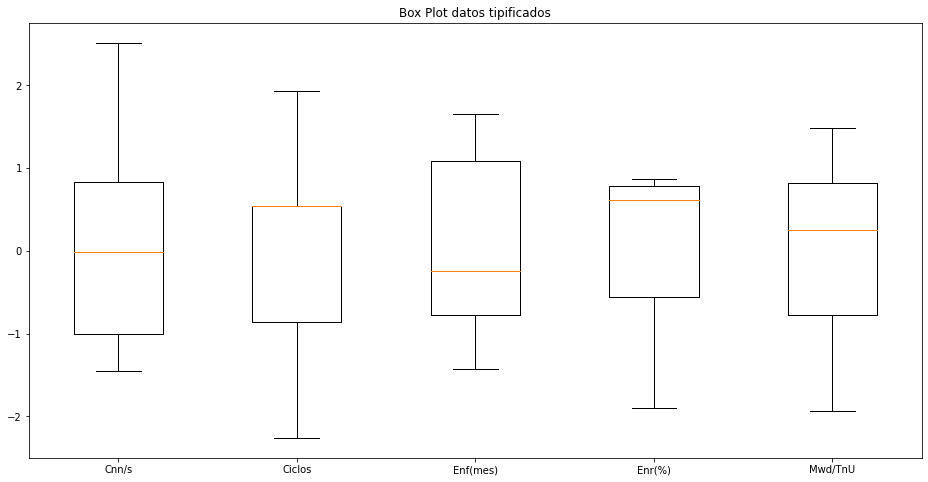

In [9]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Box Plot datos tipificados')
ax1.boxplot(data.values[:,5:10], labels=data.columns.tolist()[5:10])
plt.show()

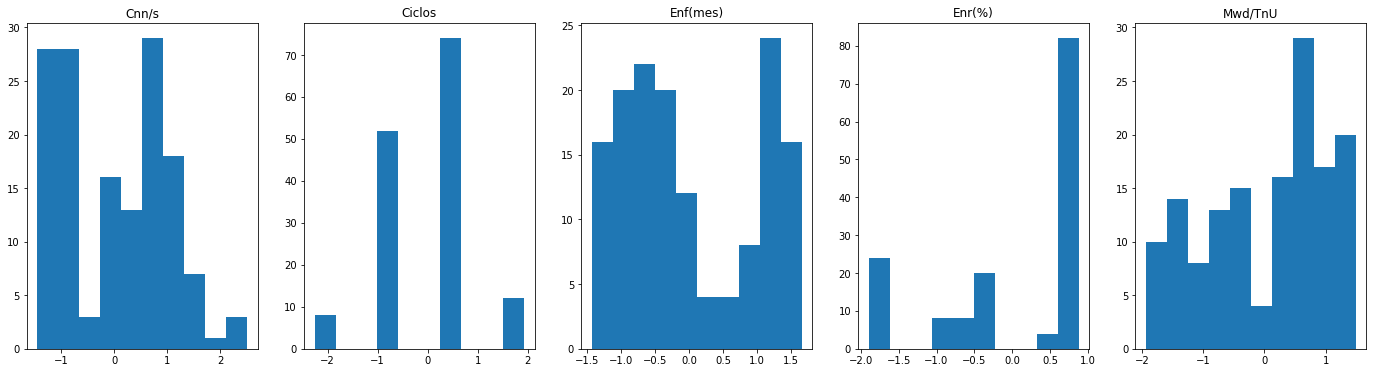

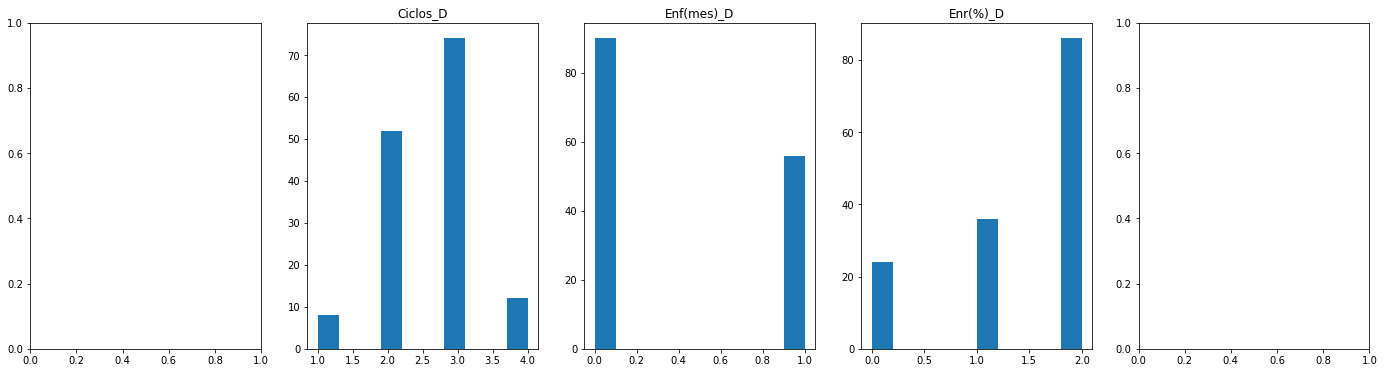

In [10]:
# Diagramas de las variables tipificadas
fig2,ax2 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax2[a].hist(data[var].values)
    ax2[a].set_title(var)
    a+1
plt.show()

# Diagramas de las variables discretizadas
fig3,ax3 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax3[a+1].hist(data[var].values)
    ax3[a+1].set_title(var)
    a+1
plt.show()
plt.close()

### Coeficiente de correlación entre Cnn/s y Mwd/TnU

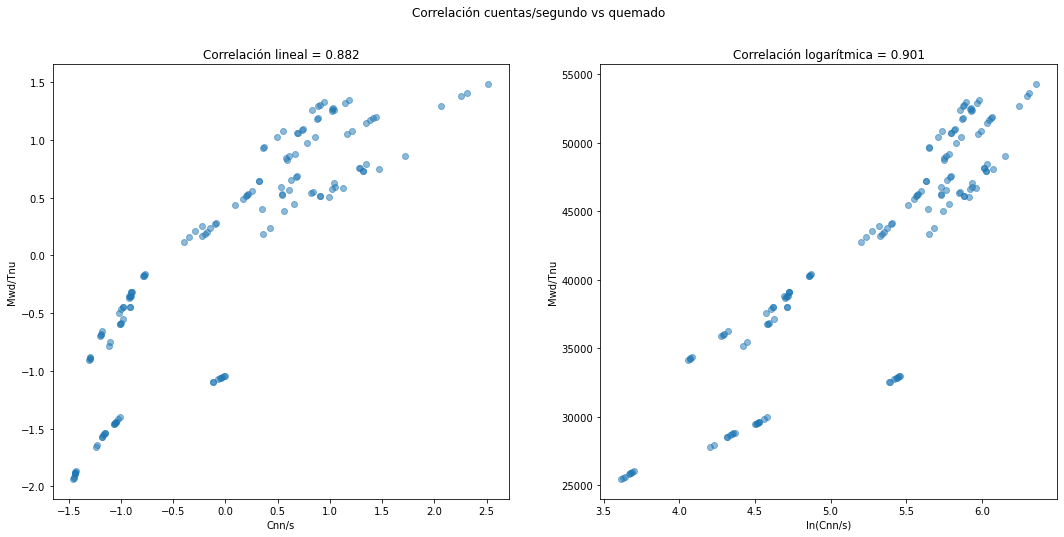

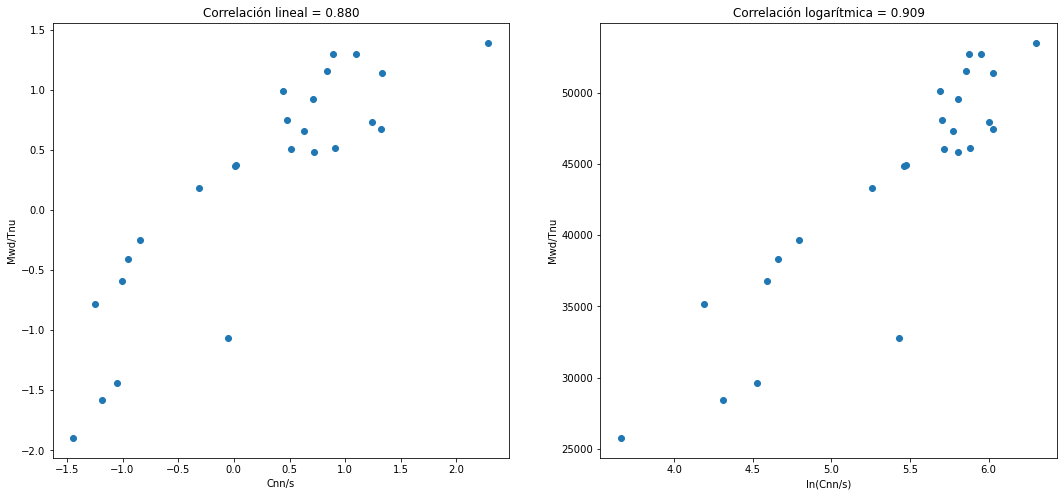

In [11]:
indep = data['Cnn/s'].values
dep = data['Mwd/TnU'].values
indepL = np.log(df['Cnn/s'].values)
depL = df['Mwd/TnU'].values

corrcoef = np.corrcoef(indep, dep)
corrcoefL = np.corrcoef(indepL, depL)


fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')

ax[1].plot(indepL, depL, 'o', alpha=0.5)
ax[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')


# Para visualizar los datos por EECC en lugar de por caras:
dataEECC = data.groupby(['EECC']).mean().drop(['Muestra'], axis=1)
dfEECC = df.groupby(['EECC']).mean().drop(['Muestra'], axis=1)
# dfEECC.info()

indepEECC = dataEECC['Cnn/s'].values
depEECC = dataEECC['Mwd/TnU'].values
indepEECCL = np.log(dfEECC['Cnn/s'].values)
depEECCL = dfEECC['Mwd/TnU'].values

corrcoef = np.corrcoef(indepEECC,depEECC)
corrcoefL = np.corrcoef(indepEECCL,depEECCL)


figEECC,axEECC = plt.subplots(1, 2, figsize=(18,8))

axEECC[0].plot(indepEECC, depEECC, 'o')
axEECC[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
axEECC[0].set_xlabel('Cnn/s')
axEECC[0].set_ylabel('Mwd/Tnu')

axEECC[1].plot(indepEECCL, depEECCL, 'o')
axEECC[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
axEECC[1].set_xlabel('ln(Cnn/s)')
axEECC[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Correlación cuentas/segundo vs quemado')

plt.show()
plt.close()

### Mínimos cuadrados:  $\beta = (X^{T}X)^{-1}X^{T}Y$

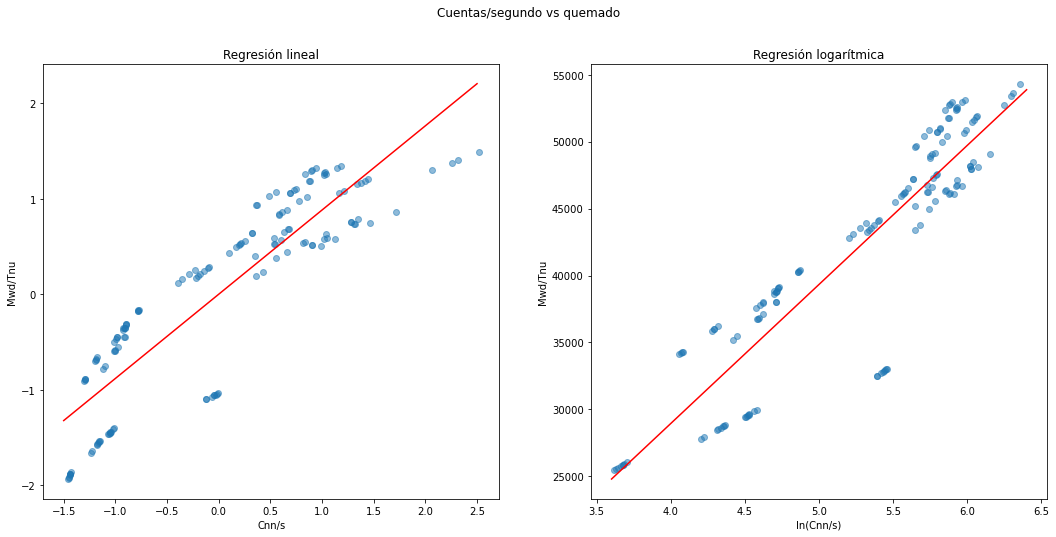

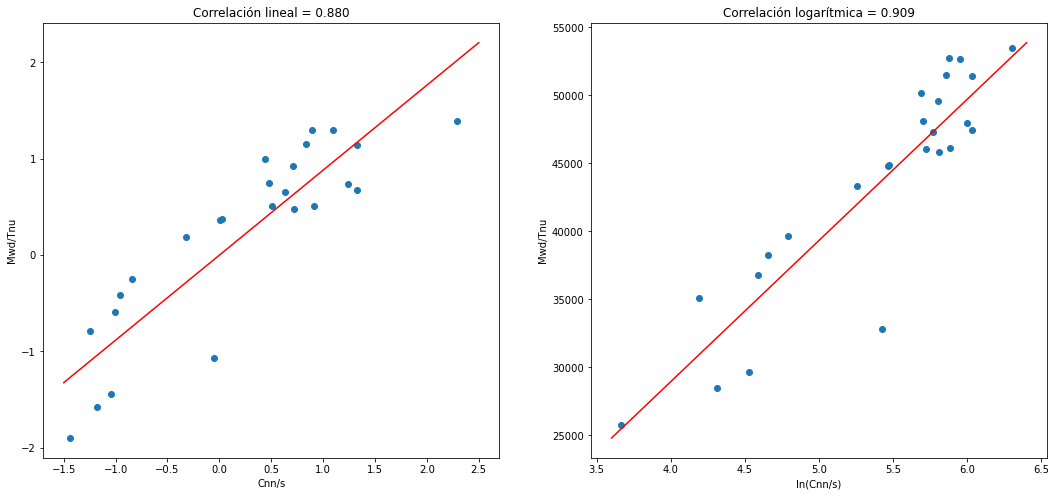

In [12]:
# Incluyo término independiente
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
XL = np.array([np.ones(df['Cnn/s'].shape[0]), np.log(df['Cnn/s'])]).T
BL = np.linalg.inv(XL.T @ XL) @ XL.T @ df['Mwd/TnU']
# print(B)
# print(BL)


# Gráficas incluyendo la línea de regresión
fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')
ax[0].plot([-1.5, 2.5], [B[0]+B[1]*(-1.5), B[0]+B[1]*2.5], c='red')

ax[1].plot(indepL, depL, 'o', alpha=0.5)
ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')
ax[1].plot([3.6, 6.4], [BL[0]+BL[1]*3.6, BL[0]+BL[1]*6.4], c='red')

figEECC,axEECC = plt.subplots(1, 2, figsize=(18,8))

axEECC[0].plot(indepEECC, depEECC, 'o')
axEECC[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
axEECC[0].set_xlabel('Cnn/s')
axEECC[0].set_ylabel('Mwd/Tnu')
axEECC[0].plot([-1.5, 2.5], [B[0]+B[1]*(-1.5), B[0]+B[1]*2.5], c='red')

axEECC[1].plot(indepEECCL, depEECCL, 'o')
axEECC[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
axEECC[1].set_xlabel('ln(Cnn/s)')
axEECC[1].set_ylabel('Mwd/Tnu')
axEECC[1].plot([3.6, 6.4], [BL[0]+BL[1]*3.6, BL[0]+BL[1]*6.4], c='red')

fig.suptitle('Cuentas/segundo vs quemado')

plt.show()
plt.close()

### Correlación separando por colores según las demás variables

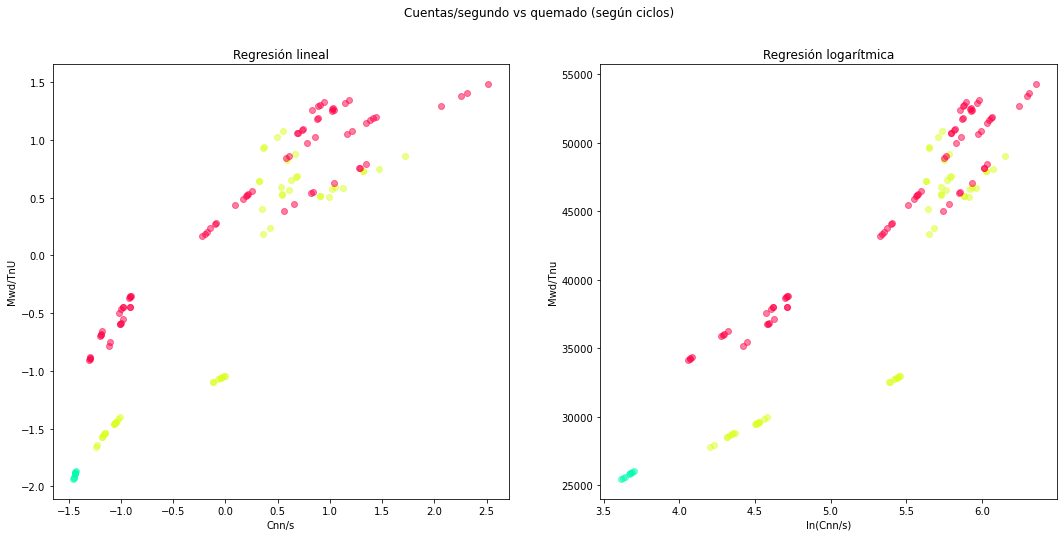

In [13]:
import matplotlib

cmap = matplotlib.cm.get_cmap('gist_ncar')

fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Ciclos_D'].values))

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Ciclos_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Ciclos_D']==i].values
    indepL = np.log(df['Cnn/s']).loc[data['Ciclos_D']==i].values
    depL = df['Mwd/TnU'].loc[data['Ciclos_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indepL,depL, 'o', alpha=0.5, c=cmap(i/colores))
    
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según ciclos)')

plt.show()
plt.close()

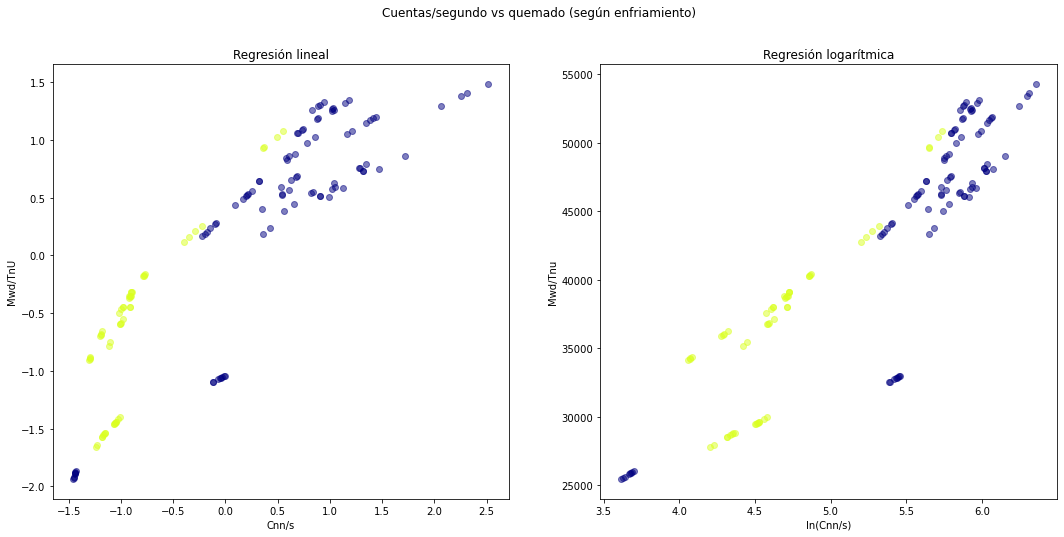

In [14]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enf(mes)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enf(mes)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enf(mes)_D']==i].values
    indepL = np.log(df['Cnn/s']).loc[data['Enf(mes)_D']==i].values
    depL = df['Mwd/TnU'].loc[data['Enf(mes)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indepL,depL, 'o', alpha=0.5, c=cmap(i/colores))
    
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según enfriamiento)')

plt.show()
plt.close()

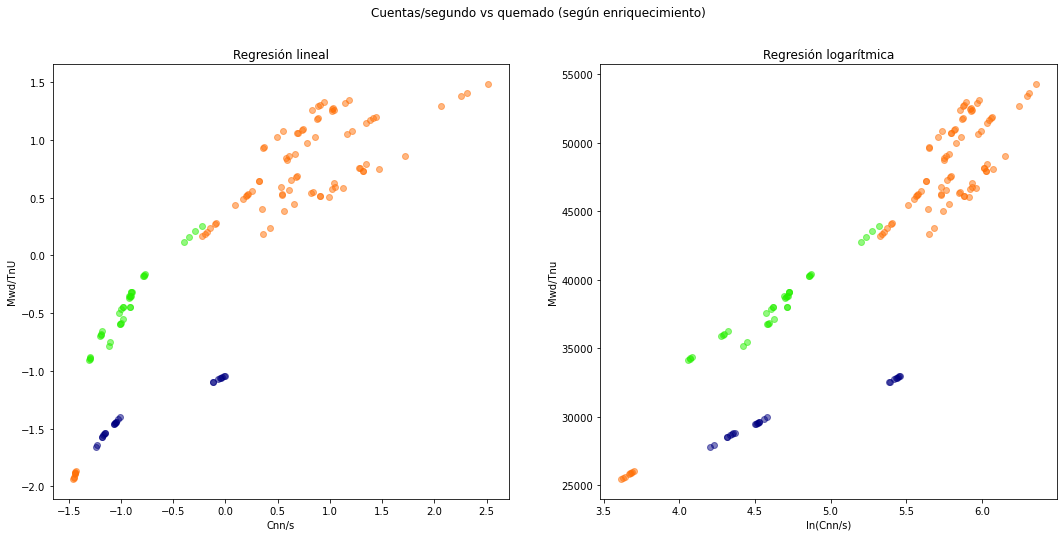

In [15]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enr(%)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enr(%)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enr(%)_D']==i].values
    indepL = np.log(df['Cnn/s']).loc[data['Enr(%)_D']==i].values
    depL = df['Mwd/TnU'].loc[data['Enr(%)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indepL,depL, 'o', alpha=0.5, c=cmap(i/colores))

ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según enriquecimiento)')

plt.show()
plt.close()

### Mínimos cuadrados con todas las variables: $\beta = (X^{T}X)^{-1}X^{T}Y$

In [16]:
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s'], data['Ciclos'], data['Enf(mes)'], data['Enr(%)']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
XL = np.array([np.ones(df['Cnn/s'].shape[0]), np.log(df['Cnn/s']), np.log(df['Ciclos']), \
               np.log(df['Enf(mes)']), np.log(df['Enr(%)'])]).T
BL = np.linalg.inv(XL.T @ XL) @ XL.T @ df['Mwd/TnU']

print(B)
print()
print(BL)

[4.345e-16 8.662e-01 1.011e-01 4.736e-01 5.258e-01]

[-48849.678   9076.753   1238.675   4287.401  15351.33 ]


Entonces:

$Mwd/Tnu \; = \; B[0] + B[1] \cdot Cnn/s + B[2] \cdot Ciclos + B[3] \cdot Enf(mes) + B[4] \cdot Enr(\%)$

$Mwd/Tnu \; = \; BL[0] + BL[1] \cdot \ln(Cnn/s) + BL[2] \cdot \ln(Ciclos) + BL[3] \cdot \ln(Enf(mes)) + BL[4] \cdot \ln(Enr(\%))$

# Método LOOCV (Leave One Out Cross Validation)

In [17]:
# df.head()

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Creo nuevos dataframes vacíos, donde iré guardando los resultados de cada iteración.
LOOCV = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])
LOOCVL = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])

# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# En cada bucle separo las 4 u 8 medidas de un elemento en "valid" y el resto de medidas las guardo en "entren"
# para hacer las regresiones con ellas, y voy almacenando los resultados en los nuevos dataframes.
agrupa = data.groupby(data.EECC)
agrupaL = df.groupby(df.EECC)

for excluido in lista:
    # print(excluido)
    
    valid = agrupa.get_group(excluido)
    valid = np.mean(valid.values[:,5:10], axis=0)
    validL = agrupaL.get_group(excluido)
    validL = np.mean(validL.values[:,5:], axis=0)
    # print(valid)
    # print(validL)
    
    entren = data[data.EECC != excluido]
    entrenL = df[df.EECC != excluido]
    # print(entren)
    # print (entrenL)
    
    X = np.array([np.ones(entren['Cnn/s'].shape[0]), entren['Cnn/s'], \
                  entren['Ciclos'], entren['Enf(mes)'], entren['Enr(%)']]).T
    B = np.linalg.inv(X.T @ X) @ X.T @ entren['Mwd/TnU']
    XL = np.array([np.ones(entrenL['Cnn/s'].shape[0]), np.log(entrenL['Cnn/s']), \
                   np.log(entrenL['Ciclos']), np.log(entrenL['Enf(mes)']), \
                   np.log(entrenL['Enr(%)'])]).T
    BL = np.linalg.inv(XL.T @ XL) @ XL.T @ entrenL['Mwd/TnU']
    
    sol = valid[4]
    calc = B[0]+B[1]*valid[0]+B[2]*valid[1]+B[3]*valid[2]+B[4]*valid[3]
    solL = validL[4]
    calcL = BL[0]+BL[1]*np.log(validL[0])+BL[2]*np.log(validL[1])+BL[3]*np.log(validL[2])+BL[4]*np.log(validL[3])
    error = ((calc - sol)/sol)*100
    errorL = ((calcL - solL)/solL)*100
    # print('{0:.2f} %'.format(error))
    # print('{0:.2f} %'.format(errorL))
    
    LOOCV = LOOCV.append({'Excluido': excluido, 'Predicción': calc, 'Validación': sol, \
                          'Error': '{0:.2f}%'.format(error)}, ignore_index = True)
    LOOCVL = LOOCVL.append({'Excluido': excluido, 'Predicción': calcL, 'Validación': solL, \
                                'Error': '{0:.2f}%'.format(errorL)}, ignore_index = True)


print('REGRESIÓN LINEAL')
display(LOOCV)
print()
rmse = mean_squared_error(LOOCV.values[:,2], LOOCV.values[:,1], squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(LOOCV.values[:,2], LOOCV.values[:,1])
print('MAE =', '{0:.2f}'.format(mae))
print()
print()
print()

print('REGRESIÓN LOGARÍTMICA')
display(LOOCVL)
print()
rmse = mean_squared_error(LOOCVL.values[:,2], LOOCVL.values[:,1], squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(LOOCVL.values[:,2], LOOCVL.values[:,1])
print('MAE =', '{0:.2f}'.format(mae))

REGRESIÓN LINEAL


,Excluido,Predicción,Validación,Error
0,BL09,0.214449,0.371791,-42.32%
1,BT18,0.783182,0.676038,15.85%
2,BR03,0.890665,0.734825,21.21%
3,BP08,2.099059,1.391645,50.83%
4,BM09,1.317191,1.141534,15.39%
5,BK49,0.875361,0.925823,-5.45%
6,BJ12,1.327539,1.295909,2.44%
7,BH08,1.033677,1.154497,-10.47%
8,BS40,-1.181718,-1.898310,-37.75%
9,BS19,0.444042,0.511959,-13.27%



RMSE = 0.26

MAE = 0.19



REGRESIÓN LOGARÍTMICA


,Excluido,Predicción,Validación,Error
0,BL09,46924.602336,44910.000,4.49%
1,BT18,45219.993301,47477.000,-4.75%
2,BR03,47103.763166,47973.000,-1.81%
3,BP08,51617.575243,53514.750,-3.55%
4,BM09,51063.353396,51404.500,-0.66%
5,BK49,50052.614033,49584.500,0.94%
6,BJ12,51980.306452,52707.000,-1.38%
7,BH08,50747.005998,51513.875,-1.49%
8,BS40,25659.830289,25756.625,-0.38%
9,BS19,45671.601801,46092.625,-0.91%



RMSE = 1308.30

MAE = 1073.06


In [26]:
# Calculo el error cuadrático medio y el error absoluto medio con los resultados tipificados
# para tener una mejor perspectiva.

calcLT = stats.zscore(LOOCVL['Predicción'])
solLT = stats.zscore(LOOCVL['Validación'])

rmse = mean_squared_error(calcLT, solLT, squared = False)
mae = mean_absolute_error(calcLT, solLT)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
print('MAE =', '{0:.2f}'.format(mae))

RMSE = 0.17

MAE = 0.14


# Regresión con Random Forest

In [20]:
data.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU,Ciclos_D,Enf(mes)_D,Enr(%)_D
ind,,,,,,,,,,,,,
1,BL09,1,1.0,0.0,0.0,-0.103873,0.536875,-0.602062,0.871258,0.273655,3.0,0.0,2.0
2,BL09,2,1.0,0.0,0.0,0.218885,0.536875,-0.602062,0.871258,0.532389,3.0,0.0,2.0
3,BL09,3,1.0,0.0,0.0,0.258954,0.536875,-0.602062,0.871258,0.562256,3.0,0.0,2.0
4,BL09,4,1.0,0.0,0.0,-0.199524,0.536875,-0.602062,0.871258,0.189741,3.0,0.0,2.0
5,BL09,5,1.0,0.0,0.0,-0.144162,0.536875,-0.602062,0.871258,0.238809,3.0,0.0,2.0


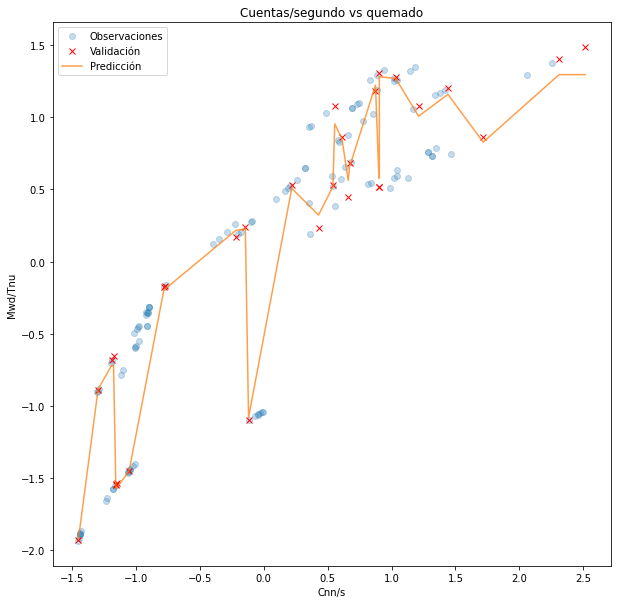

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
7,-1.451293,-1.925407,-1.923856,-0.08%
20,-1.296826,-0.891300,-0.882832,-0.95%
26,-1.191396,-0.684479,-0.718944,5.04%
21,-1.175957,-0.656982,-0.718943,9.43%
3,-1.158018,-1.545069,-1.568655,1.53%
9,-1.154856,-1.540683,-1.568655,1.82%
23,-1.149636,-1.533691,-1.566270,2.12%
22,-1.054353,-1.448592,-1.449195,0.04%
12,-0.781296,-0.174952,-0.192648,10.12%
11,-0.777032,-0.170092,-0.192648,13.26%


Precisión del entrenamiento = 99.92%
Precisión de la validación = 99.63%

RMSE = 0.06

MAE = 0.05


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# X almacena las variables independientes
# Y almacena la variable dependiente
X = data.iloc[:, 5:9].values
Y = data.iloc[:, 9].values
# print(X)
# print(Y)

# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 2000, max_depth = 6)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

Los resultados son tan extraordinariamente buenos porque he hecho completamente aleatoria la división de los conjuntos de entrenamiento y valicación, y hay datos de un mismo elemento en los dos conjuntos que son prácticamente idénticos.

Estoy validando prácticamente con los mimos datos con los que entreno.

### Repito la regresión separando en el conjunto de validación los datos completos de 5 elementos aleatorios

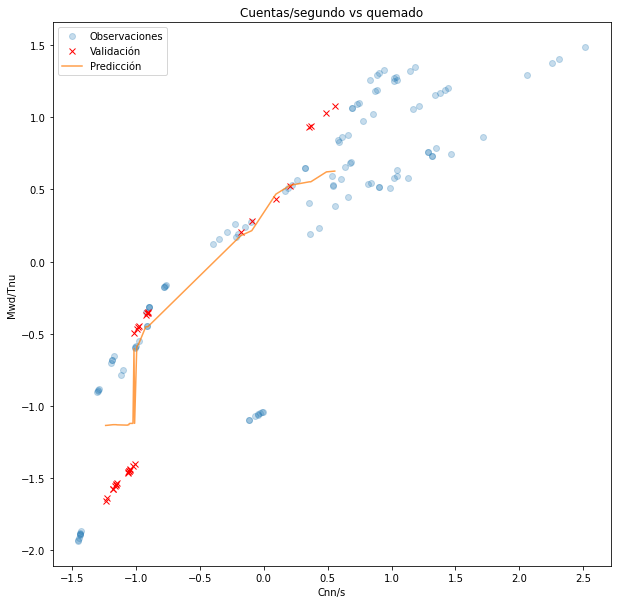

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
23,-1.237862,-1.659798,-1.134601,-31.64%
19,-1.224554,-1.639768,-1.133685,-30.86%
22,-1.179412,-1.574581,-1.129318,-28.28%
18,-1.177648,-1.572092,-1.129318,-28.16%
21,-1.167061,-1.557395,-1.129318,-27.49%
20,-1.158018,-1.545069,-1.129402,-26.90%
16,-1.154856,-1.540683,-1.129402,-26.69%
17,-1.149636,-1.533691,-1.130529,-26.29%
27,-1.066705,-1.463288,-1.132579,-22.60%
31,-1.063911,-1.459970,-1.130764,-22.55%


Precisión del entrenamiento = 99.97%
Precisión de la validación = 88.41%

RMSE = 0.31

MAE = 0.27


In [22]:
# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# Selecciono 5 elementos aleatorios y los separo, para generar un data frame de validación y otro de entrenamiento
random = np.random.choice(a=len(lista), size=5, replace=False)
# print(random)
valid = pd.DataFrame()
agrupa = data.groupby(data.EECC)
for excluidos in random:
    val = agrupa.get_group(lista[excluidos])
    valid = valid.append(val)
entren = data.drop(valid.index)
# print(valid)
# print(entren)


# Repito el proceso anterior
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 4000, max_depth = 9)
bosque.fit(Xent, Yent)
'''
EN PRINCIPIO CUANTOS MÁS ÁRBOLES MEJOR, PERO NO HE VISTO DIFERENCIA SIGNITICATIVA EN UN RANGO DE ENTRE 200 A 50000.
TAMPOCO APRECIO DIFERENCIAS ENTRE PROFUNDIADES DE VALOR ENTRE 4 Y 12.
¿HAY ALGÚN MODO DE ELEGIR EL NÚMERO DE ESTIMADORES Y DE PROFUNDIDAD MÁS ÓPTIMOS?
'''

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### Algunas veces hace buenas predicciones y otras tiene una precisión malísima

### Repito la regresión separando en el conjunto de validación los datos completos de 1 solo elemento aleatorio

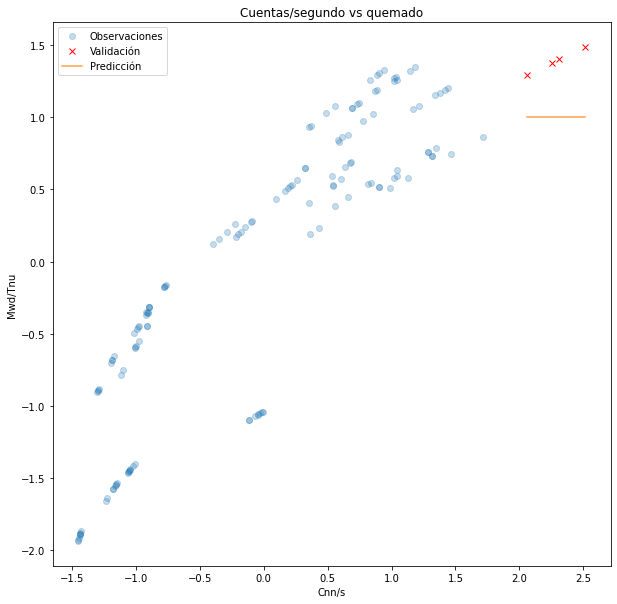

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
3,2.062867,1.296502,1.005024,-22.48%
0,2.254095,1.378993,1.005024,-27.12%
2,2.311956,1.403409,1.005024,-28.39%
1,2.516418,1.487678,1.005024,-32.44%


Precisión del entrenamiento = 99.98%
Precisión de la validación = -3219.21%

RMSE = 0.39

MAE = 0.39


In [23]:
# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# Selecciono 1 elemento aleatorio y lo separo, para generar un data frame de validación y otro de entrenamiento.
excluido = np.random.choice(a=len(lista), size=1)
agrupa = data.groupby(data.EECC)
valid = agrupa.get_group(lista[int(excluido)])
valid = pd.DataFrame(valid)
entren = data.drop(valid.index)
# print(valid)
# print(entren)


# Repito el proceso anterior
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 4000, max_depth = 9)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### La precisión también es muy variable, pero en general es mucho peor.

### Repito la regresión sutilizando los datos de los EECC completos

In [24]:
dataEECC.head()

,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU,Ciclos_D,Enf(mes)_D,Enr(%)_D
EECC,,,,,,,,,,,
BA20,0.0,0.0,0.0,-0.953354,0.536875,1.087624,-0.495481,-0.412441,3.0,1.0,1.0
BB40,0.0,0.0,0.0,-1.004625,0.536875,0.947595,-0.290950,-0.592980,3.0,1.0,1.0
BC05,0.0,0.0,0.0,-0.316771,1.936587,0.592854,-0.306929,0.186156,4.0,1.0,1.0
BG14,1.0,0.0,0.0,0.891198,0.536875,0.088749,0.684836,1.296976,3.0,0.0,2.0
BG31,1.0,0.0,0.0,0.442922,-0.862836,0.256784,0.600680,0.993114,2.0,1.0,2.0


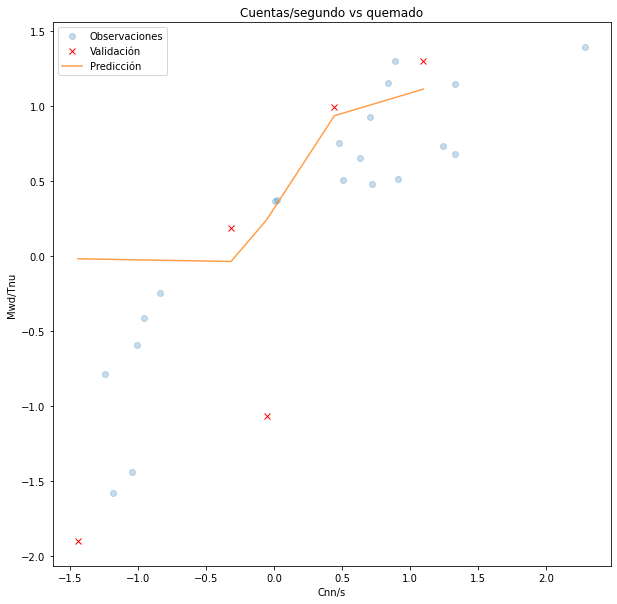

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.441800,-1.898310,-0.018741,-99.01%
4,-0.316771,0.186156,-0.036949,-119.85%
2,-0.055652,-1.064683,0.240035,-122.55%
3,0.442922,0.993114,0.933502,-6.00%
1,1.097535,1.295909,1.110639,-14.30%


Precisión del entrenamiento = 98.64%
Precisión de la validación = 27.97%

RMSE = 1.03

MAE = 0.73


In [25]:
# X almacena las variables independientes
# Y almacena la variable dependiente
X = dataEECC.iloc[:, 3:7].values
Y = dataEECC.iloc[:, 7].values
# print(X)
# print(Y)

# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 2000, max_depth = 6)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### También varía bastante.

Parece que la muestra es demasiado pequeña para que puedan hacerse buenas predicciones, al menos con estos métodos.